# Self-Driving Car Engineer Nanodegree

## Vehicle Detection 

## Project: Build an advanced lane finding algorithm


## Histogram of Oriented Gradients (HOG)

In [132]:
import numpy as np 

# for opening files
import os, sys

# for copying image and save them to disk 
import matplotlib.image as mpimg

# Plotting images 
import matplotlib.pyplot as plt 

# CV2 
import cv2

# Hog features
from skimage.feature import hog

### Load Data
Read from the data folder and load all images

In [133]:
import glob

# Define DataLoader class which can load vehicles 
class DataLoader:
    def __init__(self, baseFolder=[None]):
        self.rootdir = baseFolder;
    def loadData(self):
        car_images_regex = "./data/vehicles/*/*.png";
        car_images = glob.glob(car_images_regex);
        self.car_images = car_images;

        non_car_images_regex = "./data/non-vehicles/*/*.png"
        non_car_images = glob.glob(non_car_images_regex)
        self.non_car_images = non_car_images;


## Feature Extractor Pipeline 
The code snippets defined below define two classes FeatureExtractor and FeatureExtractor pipeline. 
These classes are used to compute and visualize HOG features 

In [134]:
### Define Feature Extractor class
class FeatureExtractor:
    # Constructor takes image or a file name of the image as input
    # When an image is input, set the image member to the image
    # Otherwise if a file name is given, load the image from the file 
    def __init__(self, is_image, image_file, root_folder=None):
        if is_image == True:
            self.image = image_file
        else:
            # For image file, if root folder is set
            if root_folder is not None:
                # Append file with root folder to get the full sequence
                s = "\\"
                sequence = (root_folder, image_file)
                file_full_path = s.join(sequence)
            else:
                file_full_path = image_file
                
            # Read from the file 
            self.image = mpimg.imread(file_full_path)
            if image_file.endswith(".png"):
                self.image = self.image.astype(np.float32)/255.0
                
        # For removing alpha dimension of the image
        self.image = self.image[:,:,:3]
    ''' applyColorSpace - converts the image to the new color space
    '''
    def applyColorSpace(self, color_space='RGB'):
        feature_image = np.copy(self.image)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)
        self.feature_image = feature_image
    ''' rescaleImage - method scales the feature_image desired scale. 
    Since the dataset images are very small, often a scale factor > 1 is used to enlarge the image
    '''
    def rescaleImage(self, scale=1):
        self.scaled_feature_image = self.feature_image
        if scale!=1:
            image_shape = self.feature_image.shape
            self.scaled_feature_image = cv2.resize(self.feature_image, (np.int(image_shape[1]/scale), np.int(image_shape[0]/scale)))

    ''' extractSpatialFeatures - method extracts spatial features as 1-d vector of image array
    It sets the extracted feature as spatial_feature member variable
    '''
    def extractSpatialFeatures(self, spatial_size=(32,32)):
        features = cv2.resize(self.scaled_feature_image, spatial_size)
        self.spatial_feature_image = features
        self.spatial_features = features.ravel()

    ''' extractHistogramFeatures - method extracts histogram features from the scale_feature_image 
    given the input number of bins
    Algorithm extracts the image into three channels and computes histogram bins for each of them.
    It then appends the histogram features of three channels and stores as histogram_features 
    '''
    def extractHistogramFeatures(self, number_of_histogram_bins=32, bins_range=(0, 256)):

        channel_1 = np.histogram(self.scaled_feature_image[:,:,0], bins=number_of_histogram_bins)
        channel_2 = np.histogram(self.scaled_feature_image[:,:,1], bins=number_of_histogram_bins)
        channel_3 = np.histogram(self.scaled_feature_image[:,:,2], bins=number_of_histogram_bins)
        self.histogram_features = np.concatenate((channel_1[0],channel_2[0], channel_3[0]))

    ''' extractHOGFeatures - method extracts HOG features from a given input channel. 
    If all channels are input for extracting HOG features, the hog features are concatenated together
    '''
    def extractHOGFeatures(self, hog_channel="ALL", orientations=9, pixels_per_cell=8, cells_per_block=2, visualise=True, feature_vec=True):
        if hog_channel=="ALL":
            input_channels=[0, 1, 2];
        else:
            input_channels = [hog_channel];

        self.hog_features = []
        for channel in input_channels:
            temp_hog_features = self.getHogFeatures(self.scaled_feature_image[:,:,channel], orientations, pixels_per_cell, cells_per_block, visualise, feature_vec)
            self.hog_features.append(temp_hog_features)
            
    ''' getHogFeatures - method extracts Histogram-Of-Gradient features for a given channel 
    It uses  a default of 9 orientations where a grid of cells are used to compute gradients.
    In the grid of cells, each cell contains 8 pixels of cell. 
    It further uses 2x2 cells as a block
    By this configuration, the entire image is split into blocks of cell, each cell consisting of 8 pixels
    Gradients are computes in 9 orientations taking into account blocks of cell
    '''
    def getHogFeatures(self, image_channel, orientations, pixel_per_cell, cell_per_block, visualise, feature_vec):
        if visualise == True:
            features, hog_image = hog(image_channel, orientations=orientations, pixels_per_cell=(pixel_per_cell, pixel_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=visualise, feature_vector=feature_vec)
            self.hog_image = hog_image
            return features, hog_image
        else:
            features = hog(image_channel, orientations=orientations, pixels_per_cell=(pixel_per_cell, pixel_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=visualise, feature_vector=feature_vec)
            return features
    ''' cropImage - crops image from ystart to ystop position 
    '''
    def cropImage(self, y_start, y_stop):
        self.image = self.image[y_start:y_stop, :, :]
                    

In [135]:
### Define feature vector for every image 
class FeatureExtractorPipeline:
    def __init__(self):
        self.y_start              = None
        self.y_stop               = None
        self.color_space          ='RGB'
        self.scale                = 1
        self.orientations         = 9
        self.pixels_per_cell      = 8
        self.cells_per_block      = 2
        self.feature_vec          = False
        self.concatenate_features = False
        self.spatial_size         = (32, 32)
        self.histogram_bins       = 32
        self.histogram_bin_range  = (0, 256)
    # execute function creates a "FeatureExtractor" object and exercises different functions 
    # from this object to extract features
    def execute(self, is_image, image_file, root_folder, concatenate_features=True):
        # Create a feature extractor object 
        featureExtractor = FeatureExtractor(is_image, image_file, root_folder);
        
        # Crop features
        # featureExtractor.cropImage(y_start, y_stop)
        
        # Apply Color Space
        featureExtractor.applyColorSpace(self.color_space)
        
        # Rescale image 
        featureExtractor.rescaleImage(self.scale)
        
        # Spatial features
        featureExtractor.extractSpatialFeatures(self.spatial_size)
        
        # Histogram features
        featureExtractor.extractHistogramFeatures(self.histogram_bins, self.histogram_bin_range)
        
        # HOG features
        featureExtractor.extractHOGFeatures("ALL", self.orientations, self.pixels_per_cell, self.cells_per_block, False, False)
        
        # Concatenate all features
        concatenated_features = []
        if concatenate_features == True:
            concatenated_features = np.concatenate((featureExtractor.spatial_features, np.ravel(featureExtractor.hog_features)))
        else:
            concatenated_features = {'spatial_features': featureExtractor.spatial_features, 'histogram_features': featureExtractor.histogram_features, 'HOG_features': featureExtractor.hog_features}
    
        self.current_feature_extractor = featureExtractor
        return concatenated_features 

## Extract and Visualizer HOG features
Use data loader to extract features for a random car vs non car image. Use the features to visualize. 

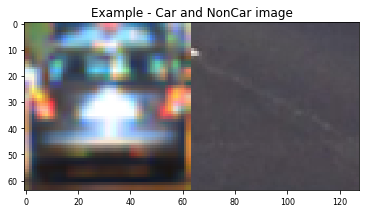

C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car / Non Car feature statistics ... 
spatial features #= 3072
histogram features #= 96
HOG features #= 3
HOG Feature Visualization


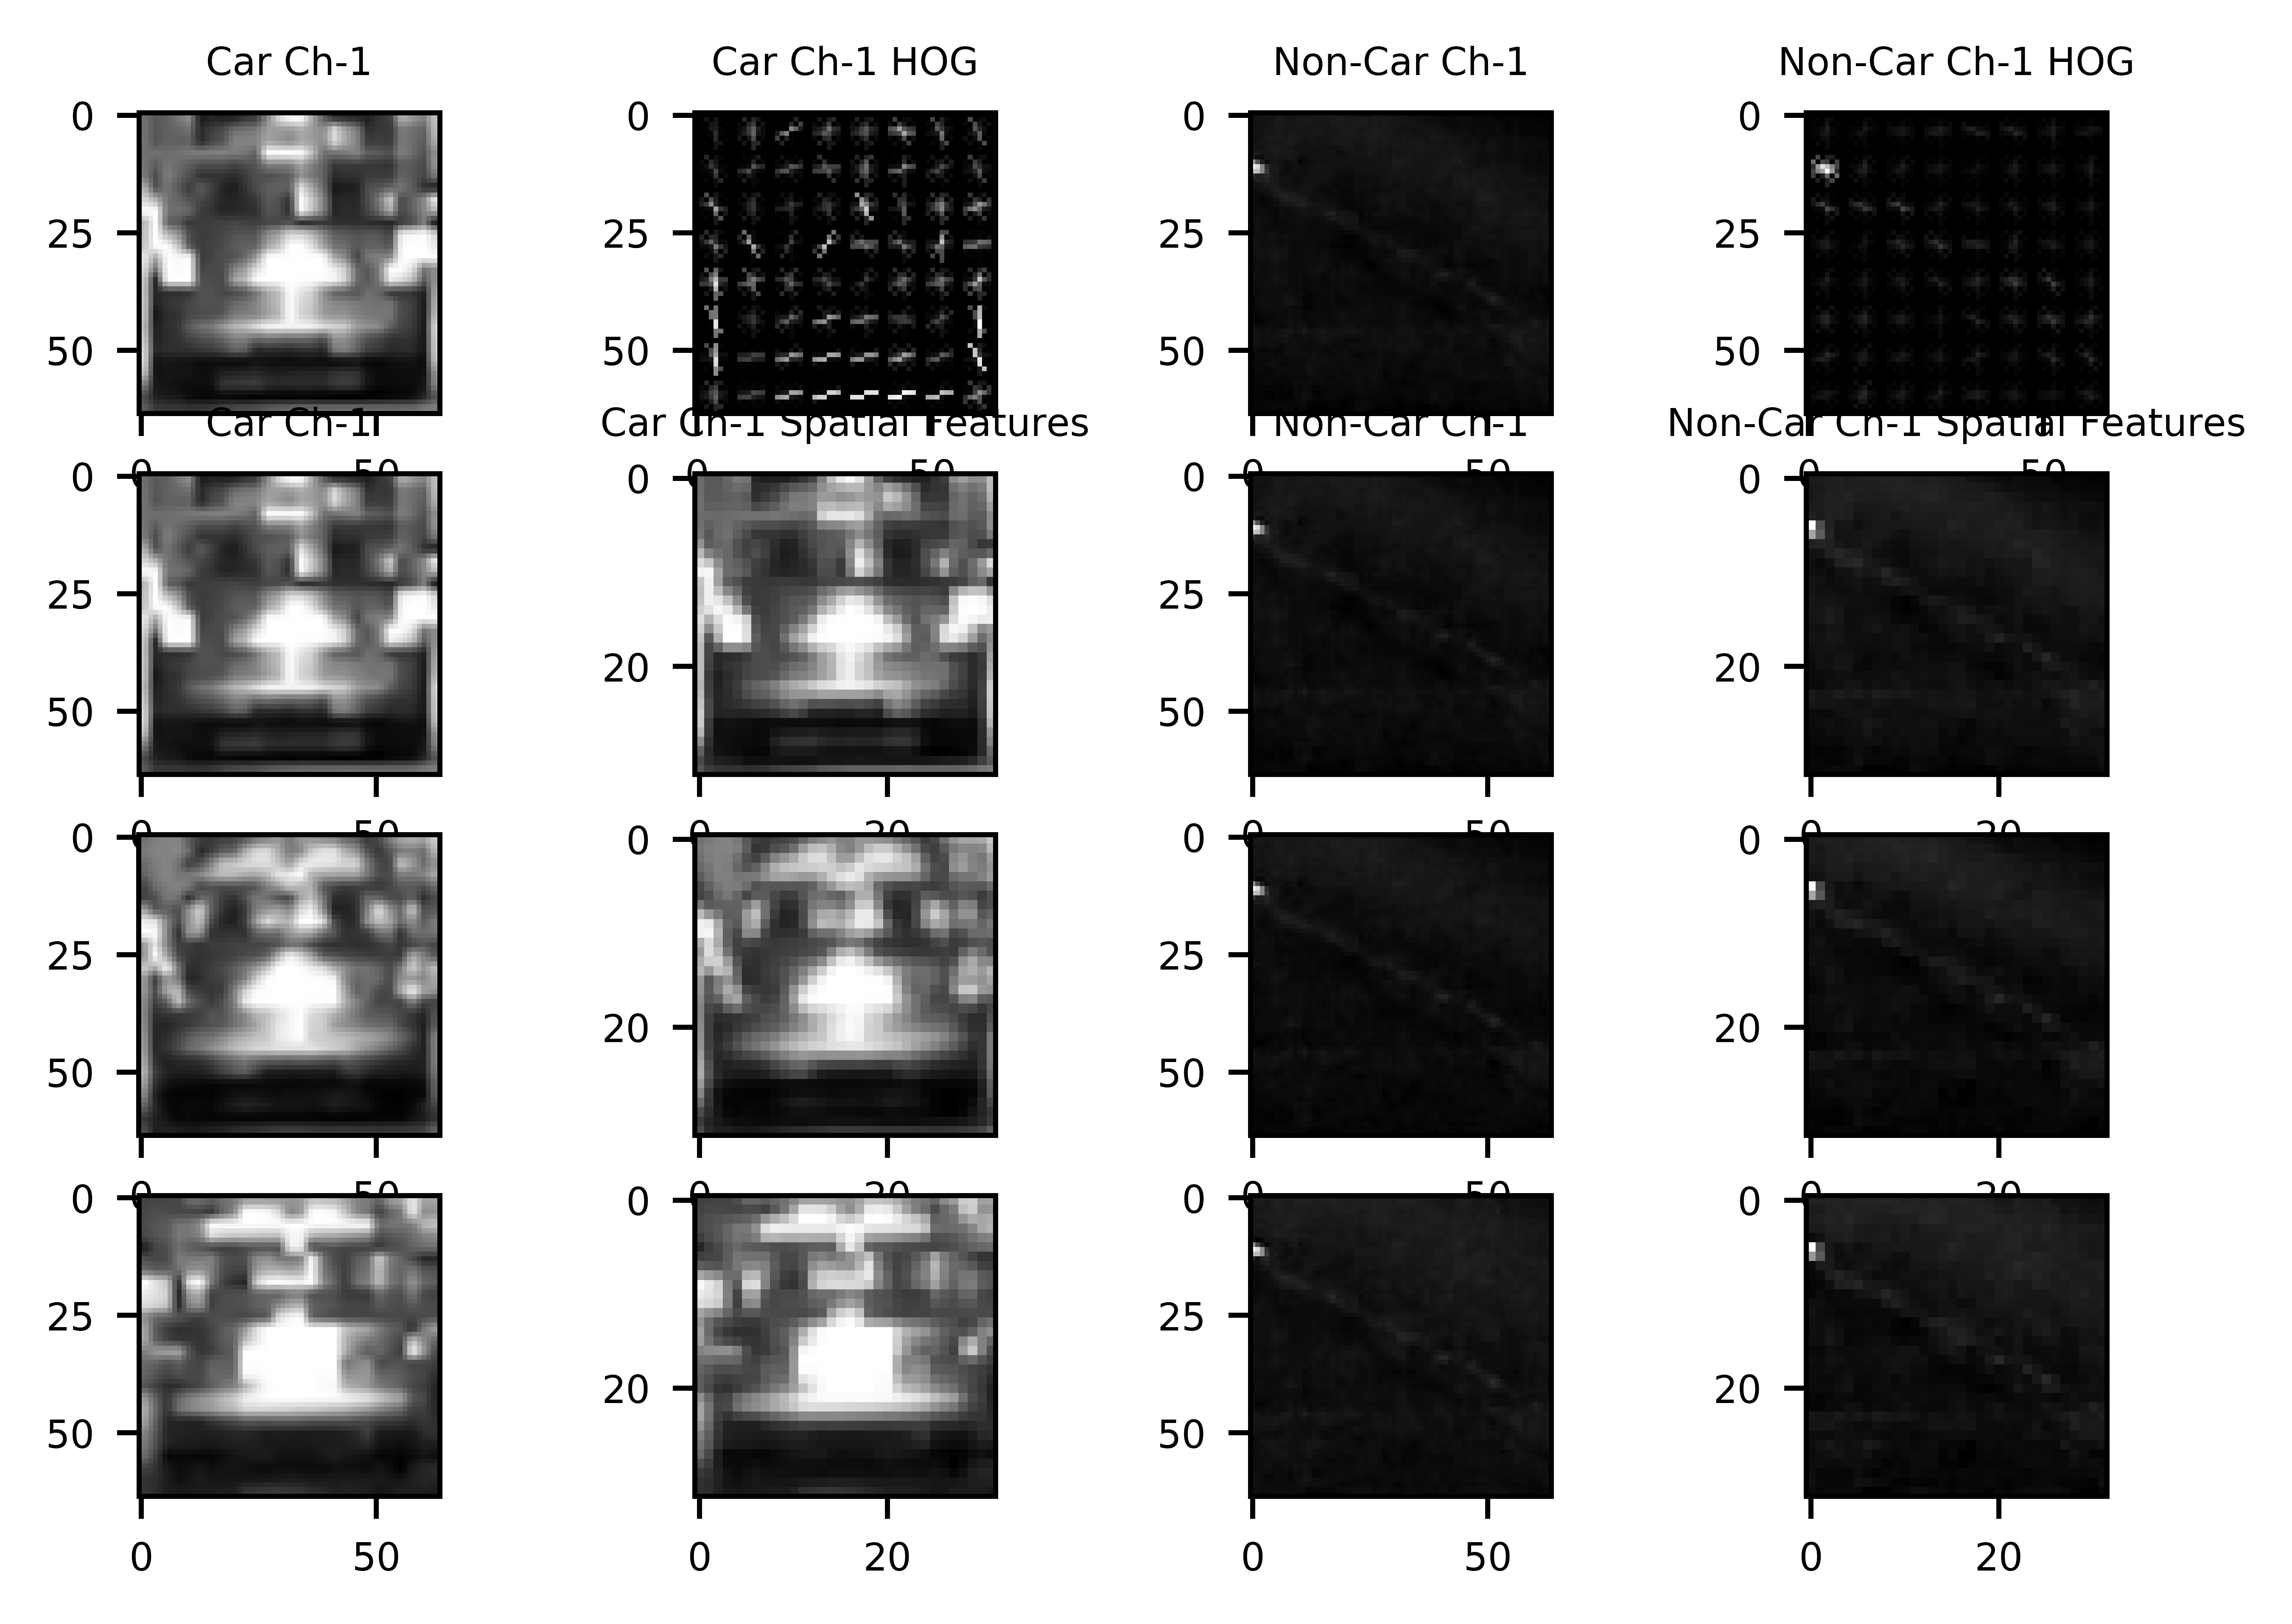

In [162]:
# Load Data Loader 
dataLoader = DataLoader()
dataLoader.loadData()

# get car and non-car images
car_images = dataLoader.car_images
non_car_images = dataLoader.non_car_images

total_cars = len(car_images)
total_non_cars = len(non_car_images)

import random
car_index = random.randint(0, total_cars)
non_car_index = random.randint(0, total_non_cars)

# Read images and visualize them
car_image = mpimg.imread(car_images[car_index])
non_car_image = mpimg.imread(non_car_images[non_car_index])

fig = plt.figure()
plot_image = np.concatenate((car_image[:,:,:3], non_car_image[:,:,:3]), axis=1)
plt.imshow(plot_image)
plt.title('Example - Car and NonCar image')
plt.show()

# Create pipeline object
featureExtractorPipeline = FeatureExtractorPipeline();

# Extract features for car image
car_features = featureExtractorPipeline.execute(False, car_images[car_index], None, False)
car_feature_image = featureExtractorPipeline.current_feature_extractor.feature_image

featureExtractorPipeline.current_feature_extractor.rescaleImage()
featureExtractorPipeline.current_feature_extractor.extractSpatialFeatures()
car_spatial_image = featureExtractorPipeline.current_feature_extractor.spatial_feature_image

featureExtractorPipeline.current_feature_extractor.extractHOGFeatures(hog_channel=0, visualise=True)
car_hog_image = featureExtractorPipeline.current_feature_extractor.hog_image 

# Extract features for non-car images
non_car_features = featureExtractorPipeline.execute(False, non_car_images[non_car_index], None, False)
non_car_feature_image = featureExtractorPipeline.current_feature_extractor.feature_image

featureExtractorPipeline.current_feature_extractor.rescaleImage()
featureExtractorPipeline.current_feature_extractor.extractSpatialFeatures()
non_car_spatial_image = featureExtractorPipeline.current_feature_extractor.spatial_feature_image

featureExtractorPipeline.current_feature_extractor.extractHOGFeatures(hog_channel=0, visualise=True)
non_car_hog_image = featureExtractorPipeline.current_feature_extractor.hog_image 

# Visualizer car and non-car
print("Car / Non Car feature statistics ... ")
print("spatial features #=", len(car_features["spatial_features"]))
print("histogram features #=", len(car_features["histogram_features"]))
print("HOG features #=", len(car_features["HOG_features"]))

print("HOG Feature Visualization")
fig, axes = plt.subplots(4, 4, dpi=1080)


# Plot Car and Non-Car HOGs
ax = plt.subplot(4,4,1)
ax.set_title("Car Ch-1", fontsize=6) 
ax.tick_params(labelsize=6)
plt.imshow(car_feature_image[:,:,0], cmap="gray")


ax = plt.subplot(4,4,2)
ax.set_title("Car Ch-1 HOG", fontsize=6)
ax.tick_params(labelsize=6)
plt.imshow(car_hog_image, cmap="gray")

ax = plt.subplot(4,4,3)
ax.set_title("Non-Car Ch-1", fontsize=6)
ax.tick_params(labelsize=6)
plt.imshow(non_car_feature_image[:,:,0], cmap="gray")

ax = plt.subplot(4,4,4)
ax.set_title("Non-Car Ch-1 HOG", fontsize=6)
ax.tick_params(labelsize=6)
plt.imshow(non_car_hog_image, cmap="gray")

ax = plt.subplot(4,4,5)
ax.set_title("Car Ch-1", fontsize=6)
ax.tick_params(labelsize=6)
plt.imshow(car_feature_image[:,:, 0], cmap="gray")

ax = plt.subplot(4,4,6)
ax.set_title("Car Ch-1 Spatial Features", fontsize=6)
ax.tick_params(labelsize=6)
plt.imshow(car_spatial_image[:,:, 0], cmap="gray")


ax = plt.subplot(4,4,7)
ax.set_title("Non-Car Ch-1", fontsize=6)
ax.tick_params(labelsize=6)
plt.imshow(non_car_feature_image[:,:, 0], cmap="gray")


ax = plt.subplot(4,4,8)
ax.tick_params(labelsize=6)
ax.set_title("Non-Car Ch-1 Spatial Features", fontsize=6)
plt.imshow(non_car_spatial_image[:,:, 0], cmap="gray")


ax = plt.subplot(4,4,9)
ax.tick_params(labelsize=6)
plt.imshow(car_feature_image[:,:, 1], cmap="gray")


ax = plt.subplot(4,4,10)
ax.tick_params(labelsize=6)
plt.imshow(car_spatial_image[:,:, 1], cmap="gray")


ax = plt.subplot(4,4,11)
ax.tick_params(labelsize=6)
plt.imshow(non_car_feature_image[:,:, 1], cmap="gray")


ax = plt.subplot(4,4,12)
ax.tick_params(labelsize=6)
plt.imshow(non_car_spatial_image[:,:, 1], cmap="gray")


ax = plt.subplot(4,4,13)
ax.tick_params(labelsize=6)
plt.imshow(car_feature_image[:,:, 2], cmap="gray")


ax = plt.subplot(4,4,14)
ax.tick_params(labelsize=6)
plt.imshow(car_spatial_image[:,:, 2], cmap="gray")


ax = plt.subplot(4,4,15)
ax.tick_params(labelsize=6)
plt.imshow(non_car_feature_image[:,:, 2], cmap="gray")


ax = plt.subplot(4,4,16)
ax.tick_params(labelsize=6)
plt.imshow(non_car_spatial_image[:,:, 2], cmap="gray")


plt.show()



### Extract Features 
For each image in the dataset, execute feature extractor pipeline and compute features
Append all features of all car and non car images and create a dataset for training SVM

In [163]:
def extractFeatures(car_images, non_car_images):
    # extract features 
    featureExtractorPipeline = FeatureExtractorPipeline();
    car_features = []
    for car in car_images:
        features = featureExtractorPipeline.execute(False, car, None, True)
        car_features.append(features[:, None])
    
    non_car_features = []
    for non_car in non_car_images:
        features = featureExtractorPipeline.execute(False, non_car, None, True)
        non_car_features.append(features[:, None])
    
    return car_features, non_car_features

# Extract features
car_features, non_car_features = extractFeatures(car_images, non_car_images)

# String all car and non car features and generate dataset for SVM
X = np.vstack((car_features, non_car_features)).astype('float64')
X = np.reshape(X, (X.shape[0], X.shape[1]))

y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

print('Dataset Statistics... ')
print("X size= ", X.shape)
print("y size= ", y.shape)


C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Dataset Statistics... 
X size=  (19168, 8364)
y size=  (19168,)


### Train SVM
After data is collected, scale the data using standard fit. Transform the data into train and test split. LinearSVC classifier is used with the extracted features. 

In [170]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
import pickle

# Data Preprocessing. 
# Scale data
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split data into training and validation datasets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state = rand_state)

# Train a classifier
clf = LinearSVC()
clf.fit(X_train, y_train)

# Predict using the trained classifier on the test set 
true_prediction = clf.predict(X_test)

# Compute test accuracy
accuracy = accuracy_score(true_prediction, y_test)

print("Test accuracy = ", accuracy)

# Save classifier
data = {'Classifier': clf, 'X': X, 'y': y, 'Scalar': X_scaler}
pickle_file_name = 'CarSVC.p'
pickle.dump(data, open(pickle_file_name, "wb"))

Test accuracy =  0.985393844549


## Detect Vehicles Pipeline 
Use LinearSVC classifier is used to detect vehicles by dividing image into small segments using sliding windows technique suggested in the lectures 

In [204]:
class SlidingWindowConfigurator:
    def __init__(self, pixels_per_cell, cells_per_block, window_size, cells_per_step):
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.window_size = window_size
        self.cells_per_step = 2
    def computeNumberOfBlocks(self, image):
        ydim = image.shape[0];
        xdim = image.shape[1];

        self.number_of_xblocks = xdim//self.pixels_per_cell - self.cells_per_block + 1;
        self.number_of_yblocks = ydim//self.pixels_per_cell - self.cells_per_block + 1;
    def computeNumberOfBlocksInWindow(self):
        self.number_of_blocks_per_window = self.window_size//self.pixels_per_cell - self.cells_per_block + 1;

    def computeSlidingWindowSteps(self):
        self.number_of_xsteps = (self.number_of_xblocks - self.number_of_blocks_per_window) // self.cells_per_step
        self.number_of_ysteps = (self.number_of_yblocks - self.number_of_blocks_per_window) // self.cells_per_step	


    def slideWindow(image, x_start_stop=[None, None], y_start_stop=[None,None], xy_window=(64,64), xy_overlap=(0.5,0.5)):
        if x_start_stop[0] == None:
            x_start_stop[0] = 0;
        if x_start_stop[1] == None:
            x_start_stop[1] = image.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0;
        if y_start_stop[1]  == None:
            y_start_stop[1] = image.shape[0];

        # Compute xy span
        xspan = x_start_stop[1] - x_start_stop[0];
        yspan = y_start_stop[1] - y_start_stop[0]; 

        # Compute number of pixels per step in x/y 
        nx_pixels_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
        ny_pixels_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))

        # Compute number of windows in x/y
        nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
        ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))

        nx_windows = np.int((xspan-nx_buffer)/nx_pixels_per_step)
        ny_windows = np.int((yspan-ny_buffer)/ny_pixels_per_step)

        window_list = []

        for ys in range(ny_windows):
            for xs in range(nx_windows):
                startx = xs *nx_pixels_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pixels_per_step + y_start_stop[0]
                endy = starty+xy_window[1]

                window_list.append(((startx, starty), (endx, endy)))

        return window_list

In [208]:
from scipy.ndimage.measurements import label
class SlidingWindowsPipeline:
    def __init__(self, root_folder, output_folder, clf, scalar):
        self.root_folder = root_folder
        self.output_folder = output_folder
        self.svm_classifier = clf
        self.scalar = scalar
        self.x_start_stop=[700, 1296]
        self.y_start_stop = [400, 600]
        self.windows_sizes = [96, 128];
        self.xy_overlaps = [0.5, 0.8]
        self.box_colors = [(0,0, 255), (0,255,0), (255,0,0), (0, 255, 255), (255, 255, 0),(255,0,255), (0, 128, 255)];
        self.threshold = 4;
        self.frame_count = 0
        
    def execute(self, image, file_name):
        self.image = image
        
        another_copy_image = np.copy(self.image)
        heat = np.zeros_like(self.image[:,:,0]).astype(np.float)
        
        image_with_boxes_annotation, detected_windows = self.detect_vehicle();
        mpimg.imsave(self.output_folder + "/" + file_name +"_boxes.png" , image_with_boxes_annotation);
        
        heat = self.add_heat(heat, detected_windows)
        heat = self.apply_threshold(heat, self.threshold)
        
        heatmap = np.clip(heat, 0, 255)
        mpimg.imsave(self.output_folder + "/" + file_name +"_heatmap.png" , heatmap, cmap="hot");
        
        labels = label(heatmap)
        
        another_copy_image = self.draw_labeled_bboxes(another_copy_image, labels)
        return another_copy_image
    def add_heat(self, heatmap, windows):
        # Iterate through list of bboxes
        for window in windows:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "window" takes the form ((x1, y1), (x2, y2))
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes
    
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, image, labels):
        imcopy = np.copy(image)
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
        return imcopy

    def draw_boxes(self, image, bboxes, color=(0,0,255), thick=6):
        imcopy = np.copy(image)
        for bbox in bboxes:
            imcopy = cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        return imcopy

    def detect_vehicle(self):
        copied_image = np.copy(self.image)
        
        boxes_image = []
        all_windows = []
        index = 0
        
        sliding_windows_image = np.copy(self.image)
        for window_size in self.windows_sizes:
            windows = [];
            for overlap in self.xy_overlaps:
                tempWindows = SlidingWindowConfigurator.slideWindow(image=copied_image, x_start_stop=self.x_start_stop, y_start_stop=self.y_start_stop, 
                        xy_window=(window_size, window_size), xy_overlap=(overlap, overlap))
                windows.extend(tempWindows)
            
            sliding_windows_image = self.draw_boxes(sliding_windows_image, windows, self.box_colors[index], thick=6)
            
            
            on_windows = [];
            count = 0
            for window in windows:
                sub_image_segment = cv2.resize(featureExtractor.image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
                
                featureExtractorPipeline = FeatureExtractorPipeline();
                sub_image_features = featureExtractorPipeline.execute(True, sub_image_segment, None, True)
                
                if self.scalar.mean_.shape[0] == sub_image_features.shape[0]:
                    test_features = self.scalar.transform(np.array(sub_image_features).reshape(1,-1))
                    prediction = self.svm_classifier.predict(test_features);
                    if prediction == 1:
                        on_windows.append(window)
                else:
                    print(self.scalar.mean_.shape[0])
                    print(sub_image_features.shape[0])
                count+=1
            
            copied_image = self.draw_boxes(copied_image, on_windows, self.box_colors[index], thick=6)
            all_windows.extend(on_windows)
            index=index+1
        #mpimg.imsave("./examples/sliding_windows.png", sliding_windows_image)
        return copied_image, all_windows

In [209]:

def process_vehicles(image):
    global frame_count

    #image = cc.undistort(image)
    file_name = "image_"+ str(frame_count) + ".jpg";
    mpimg.imsave(file_name, image);

    frame_count += 1
    output_folder = "./test_videos_output"
    output_image = detect_vehicle(False, file_name, ".", output_folder)
    return output_image


pickle_file_name = "CarSVC.p"
data = pickle.load(open(pickle_file_name, "rb"));
clf = data['Classifier'];
scalar = data['Scalar'];

root_folder = "test_images";
output_folder = "test_images_output"
slidingWindowPipeline  = SlidingWindowsPipeline(root_folder, output_folder, clf, scalar)

file_list = os.listdir(root_folder)
for file in file_list:
    if file.endswith(".jpg") or file.endswith(".png"):
        print("Annotating " + file)
        file_parts = file.split(".")

        featureExtractor = FeatureExtractor(False, file, root_folder)
        plt.imshow(featureExtractor.image)
        annotated_image = slidingWindowPipeline.execute(featureExtractor.image, file_parts[0])
        mpimg.imsave(output_folder + "/" + file_parts[0] + "_annotated.png", annotated_image); 


Annotating test1.jpg


C:\Users\Vaidehi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Annotating test2.jpg
Annotating test3.jpg
Annotating test4.jpg
Annotating test5.jpg
Annotating test6.jpg


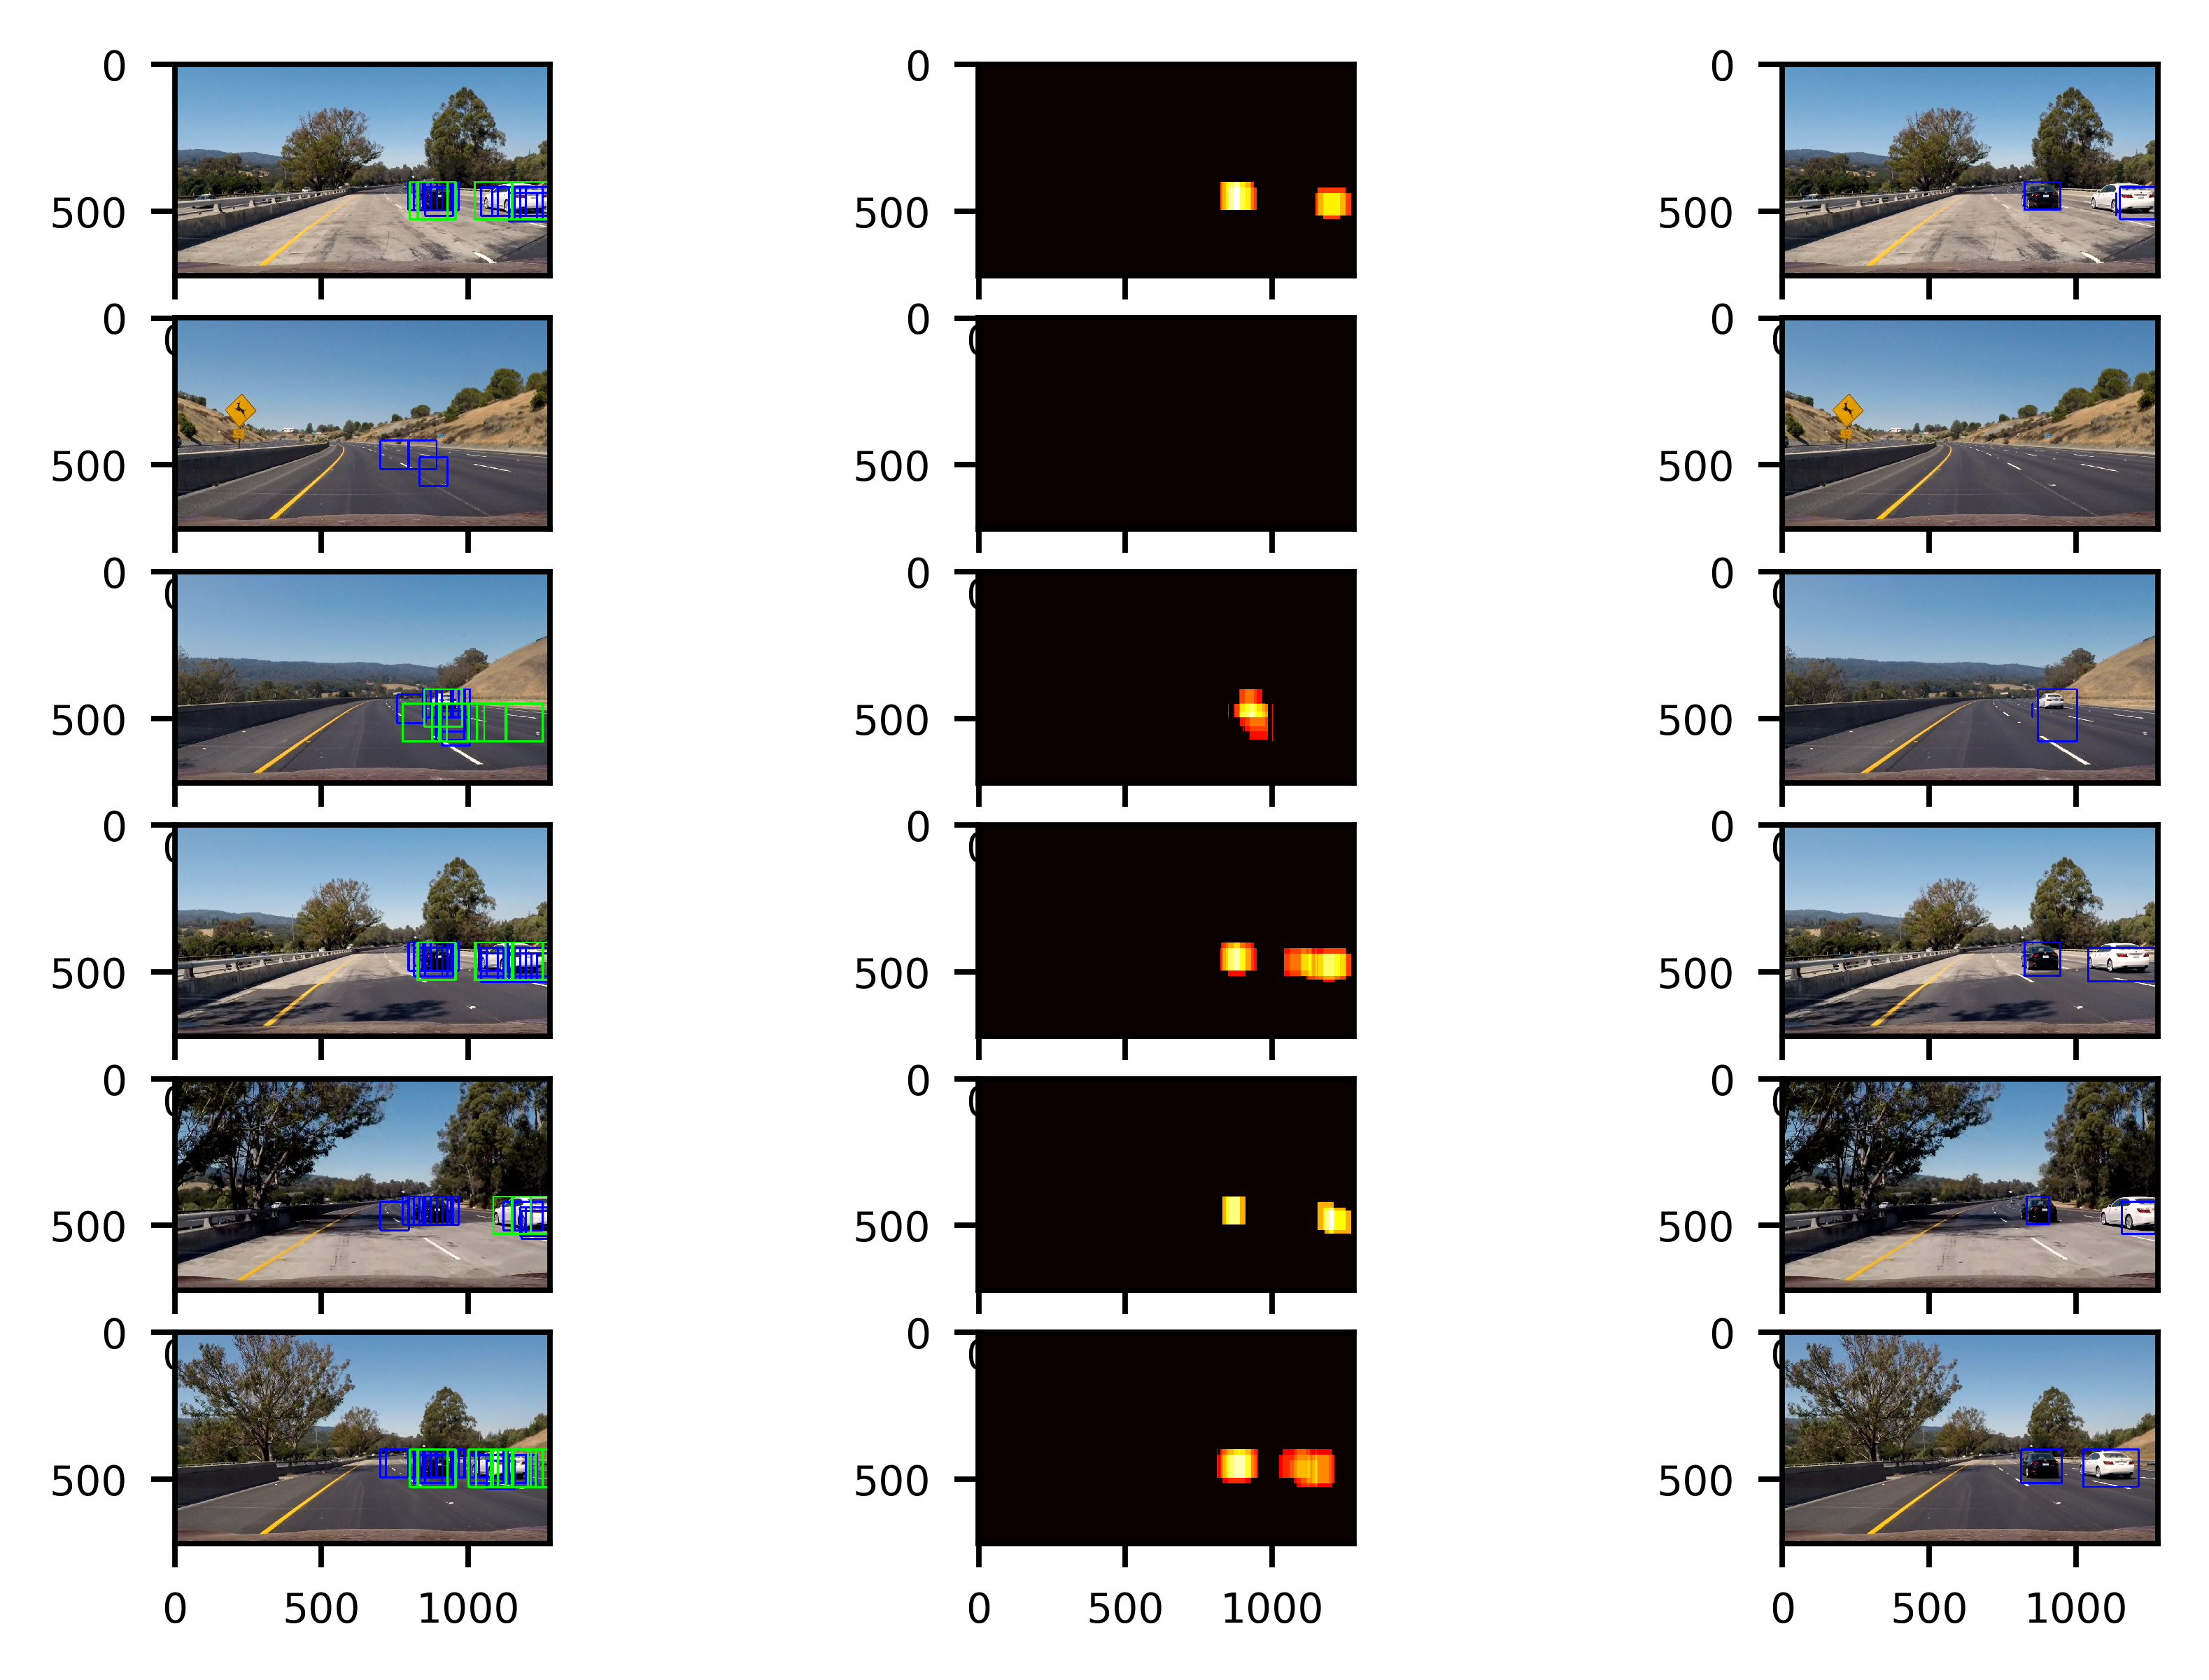

In [207]:
root_folder = "test_images_output/bboxes_heatmap/";

fig = plt.figure(dpi=700)
image_index = int(1);
for idx in range(6):
    file_suffix = str(idx + 1)
    file_prefix = root_folder + "test" + file_suffix
    
    file_name_hm = file_prefix + "_heatmap.png"
    file_name_bb = file_prefix + "_boxes.png"
    file_name_output = file_prefix + "_annotated.png"
    
    bimage = mpimg.imread(file_name_bb)
    ax = fig.add_subplot(6,3, image_index)
    ax.tick_params(labelsize=6)
    plt.imshow(bimage)
    image_index+=1
    
    himage = mpimg.imread(file_name_hm)
    ax = fig.add_subplot(6,3, image_index)
    ax.tick_params(labelsize=6)
    plt.imshow(himage, cmap="hot")
    image_index+=1
    
    oimage = mpimg.imread(file_name_output)
    ax = fig.add_subplot(6,3, image_index)
    ax.tick_params(labelsize=6)
    plt.imshow(oimage)
    image_index +=1
plt.show()